# Code for running a recurrent neural network on C-AFM (conductive atomic force microscopy) data.

Tested with tensorflow 1.13.1 and keras 2.2.4

# Preprocessing
Preprocessing is done to convert the data from the CSV file supplied to a format suitable for importing to the neural network

Preprocessing can be ferformed by the script prepare_data.py, or running the cell below.

The following files are produced:

prosessedY.npy <- data for the neural network

prosessedY.npy <- X-axis for plotting the data

std.npy  <- standard deviation for transforming the preprocessed data back to the original parameter space

mean.npy  <- mean for transforming the preprocessed data back to the original parameter space

binsize.npy <- the binsize


In [1]:
import numpy as np
import xlrd
import types
import NN.preprocessing
'''
read the xls file
'''
wb = xlrd.open_workbook('_I_(BV)_1 (1).xls')
sheet1 = wb.sheet_by_index(0)


arr = []
for row in range(1, sheet1.nrows):
    arr.append([])
    for col in range(sheet1.ncols):
        arr[-1].append(float(sheet1.cell(row, col).value))
arr = np.array(arr)
arr = arr.swapaxes(0, 1)
current = []
for i in range(40):
    current.append([])
    for j in range(40):
        current[-1].append([])
        for k in range(arr.shape[1]):
            current[-1][-1].append([arr[(i*40+j)*4+1, k], arr[(i*40+j)*4+3, k]])

current = np.array(current)
'''
prepare data for the neural net
'''
bins = 75
data = types.SimpleNamespace()
data.I = current
data.V = arr[0]
data.V = np.swapaxes([-data.V[::-1], -data.V], 0, 1)
# reduce dimensionality
data.IShort, binsize, startCutoff = NN.preprocessing.reduce_dimensionality(
    data.I, bins, extra_output=True)
data.VShort = NN.preprocessing.reduce_dimensionality(data.V, bins)
# normalize
data.INorm, std, mean = NN.preprocessing.normalize(
    data.IShort, extra_output=True)
#save
trainingforML = np.array(data.INorm)
np.save('std', std)
mean=mean-51.32 # The current has an offset of 51.32 pA 
np.save('mean', mean)
np.save('binsize', binsize)
np.save('prosessedY', trainingforML)
data.VShort=data.VShort*15 # a 15X amplifier was used for the measurement, i.e. the range goes from 0 to 15 V
np.save('prosessedX', data.VShort)
print('preprocessing done')


Using TensorFlow backend.


(40, 40, 601, 2)
Averaging to 75 on rising and falling end
Averaging over 8 datapoints
cutting 1 datapoint on each end
(601, 2)
Averaging to 75 on rising and falling end
Averaging over 8 datapoints
cutting 1 datapoint on each end
preprocessing done


# Running the network
The network can be run by runnign the script runNN.py or the cell below.

In the cell below the number of epochs is reduced, to limit the runtime

In [2]:
import NN
import numpy as np
import tensorflow as tf


# os.environ["CUDA_DEVICE_ORDER"]="1,0" # disables GPU to run on CPU
# Used to select graphics card on multiple GPU setup
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# set to allow dynamic allocation of memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

################# set config
layer_type = 'LSTM'
size = 64
encode_layers = 4
# decode_layers = 4 # will be same as encode_layers
embedding = 16
activation='relu'
learning_rate = 3e-5
dropout = 0.2
l1_norm = 2e-5
batch_norm = [1, 1]
batch_size = 450
epochs = 1000
scale=False

postfix = ''
# load data
trainingforML = np.load('prosessedY.npy')
# initialize model
model = NN.NN(input_data_size=trainingforML.shape[-2], input_data_dim=trainingforML.shape[-1],
              num_encoding_layers=encode_layers, size_encoding_layers=size, num_embeddings=embedding,
              learning_rate=learning_rate, dropout=dropout, bidirectional=True, l1_norm=l1_norm, layer_type=layer_type,
              batch_norm=batch_norm,scale=scale, loss_type='mse', postfix=postfix)
# train model
model.train(trainingforML.reshape((-1, trainingforML.shape[-2], trainingforML.shape[-1])),
            data_val=None, folder=None,
            batch_size=batch_size, epochs=epochs, seed=10)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
1600/1600 [==============================] - 37s 23ms/step - loss: 1.0424
Epoch 2/1000
1600/1600 [==============================] - 25s 16ms/step - loss: 1.0359
Epoch 3/1000
1600/1600 [==============================] - 25s 16ms/step - loss: 1.0288
Epoch 4/1000
1600/1600 [==============================] - 26s 16ms/step - loss: 1.0235
Epoch 5/1000
1600/1600 [==============================] - 25s 15ms/step - loss: 1.0186
Epoch 6/1000
1600/1600 [==============================] - 25s 15ms/step - loss: 1.0150
Epoch 7/1000
1600/1600 [==============================] - 26s 16ms/step - loss: 1.0090
Epoch 8/1000
1600/1600 [==============================] - 25s 16ms/step - loss: 1.0042
Epoch 9/1000
1600/1600 [==============================] - 25s 16ms/st

1600/1600 [==============================] - 25s 16ms/step - loss: 0.1643
Epoch 85/1000
1600/1600 [==============================] - 25s 16ms/step - loss: 0.1605
Epoch 86/1000
1600/1600 [==============================] - 25s 16ms/step - loss: 0.1584
Epoch 87/1000
1600/1600 [==============================] - 25s 16ms/step - loss: 0.1580
Epoch 88/1000
1600/1600 [==============================] - 25s 16ms/step - loss: 0.1540
Epoch 89/1000
1600/1600 [==============================] - 25s 16ms/step - loss: 0.1523
Epoch 90/1000
1600/1600 [==============================] - 25s 16ms/step - loss: 0.1499
Epoch 91/1000
1600/1600 [==============================] - 25s 15ms/step - loss: 0.1472
Epoch 92/1000
1600/1600 [==============================] - 22s 14ms/step - loss: 0.1457
Epoch 93/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.1444
Epoch 94/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.1417
Epoch 95/1000
1600/1600 [=====================

1600/1600 [==============================] - 18s 11ms/step - loss: 0.0769
Epoch 177/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0758
Epoch 178/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0753
Epoch 179/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0744
Epoch 180/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0744
Epoch 181/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0739
Epoch 182/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0739
Epoch 183/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0731
Epoch 184/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0732
Epoch 185/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0726
Epoch 186/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0724
Epoch 187/1000
1600/1600 [==========

1600/1600 [==============================] - 18s 11ms/step - loss: 0.0498
Epoch 269/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0495
Epoch 270/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0488
Epoch 271/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0486
Epoch 272/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0485
Epoch 273/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0482
Epoch 274/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0481
Epoch 275/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0477
Epoch 276/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0476
Epoch 277/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0475
Epoch 278/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0473
Epoch 279/1000
1600/1600 [==========

1600/1600 [==============================] - 19s 12ms/step - loss: 0.0366
Epoch 361/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0373
Epoch 362/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0368
Epoch 363/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0369
Epoch 364/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0371
Epoch 365/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0366
Epoch 366/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0368
Epoch 367/1000
1600/1600 [==============================] - 18s 12ms/step - loss: 0.0366
Epoch 368/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0365
Epoch 369/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0360
Epoch 370/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0361
Epoch 371/1000
1600/1600 [==========

1600/1600 [==============================] - 18s 11ms/step - loss: 0.0303
Epoch 453/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0302
Epoch 454/1000
1600/1600 [==============================] - 21s 13ms/step - loss: 0.0310
Epoch 455/1000
1600/1600 [==============================] - 20s 12ms/step - loss: 0.0301
Epoch 456/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0305
Epoch 457/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0307
Epoch 458/1000
1600/1600 [==============================] - 22s 13ms/step - loss: 0.0300
Epoch 459/1000
1600/1600 [==============================] - 21s 13ms/step - loss: 0.0296
Epoch 460/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0302
Epoch 461/1000
1600/1600 [==============================] - 20s 13ms/step - loss: 0.0302
Epoch 462/1000
1600/1600 [==============================] - 20s 12ms/step - loss: 0.0312
Epoch 463/1000
1600/1600 [==========

1600/1600 [==============================] - 18s 11ms/step - loss: 0.0265
Epoch 545/1000
1600/1600 [==============================] - 18s 12ms/step - loss: 0.0268
Epoch 546/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0278
Epoch 547/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0269
Epoch 548/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0270
Epoch 549/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0270
Epoch 550/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0270
Epoch 551/1000
1600/1600 [==============================] - 21s 13ms/step - loss: 0.0265
Epoch 552/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0265
Epoch 553/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0264
Epoch 554/1000
1600/1600 [==============================] - 18s 12ms/step - loss: 0.0267
Epoch 555/1000
1600/1600 [==========

1600/1600 [==============================] - 18s 11ms/step - loss: 0.0243
Epoch 637/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0244
Epoch 638/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0236
Epoch 639/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0243
Epoch 640/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0237
Epoch 641/1000
1600/1600 [==============================] - 18s 12ms/step - loss: 0.0244
Epoch 642/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0234
Epoch 643/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0240
Epoch 644/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0232
Epoch 645/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0239
Epoch 646/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0246
Epoch 647/1000
1600/1600 [==========

1600/1600 [==============================] - 19s 12ms/step - loss: 0.0222
Epoch 729/1000
1600/1600 [==============================] - 18s 12ms/step - loss: 0.0215
Epoch 730/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0214
Epoch 731/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0214
Epoch 732/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0215
Epoch 733/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0218
Epoch 734/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0217
Epoch 735/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0216
Epoch 736/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0221
Epoch 737/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0214
Epoch 738/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0212
Epoch 739/1000
1600/1600 [==========

1600/1600 [==============================] - 18s 11ms/step - loss: 0.0200
Epoch 821/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0201
Epoch 822/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0199
Epoch 823/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0203
Epoch 824/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0203
Epoch 825/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0198
Epoch 826/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0198
Epoch 827/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0202
Epoch 828/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0198
Epoch 829/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0196
Epoch 830/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0202
Epoch 831/1000
1600/1600 [==========

1600/1600 [==============================] - 18s 11ms/step - loss: 0.0192
Epoch 913/1000
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0190
Epoch 914/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0188
Epoch 915/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0190
Epoch 916/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0186
Epoch 917/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0190
Epoch 918/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0190
Epoch 919/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0186
Epoch 920/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0186
Epoch 921/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0188
Epoch 922/1000
1600/1600 [==============================] - 18s 11ms/step - loss: 0.0185
Epoch 923/1000
1600/1600 [==========

# Visualize results

The results can be visualized in multiple different ways. The script monitor.py can be run in order to visualize the results. This script is designed to run in parallel to the model, so that the progess of the network can be tracked. A singe plot to visualize the results of the model just made, can be created by running the cell below

In [3]:
import sys
sys.path.append('.')
import monitor
print(model.folder)
path = model.folder
data = np.load('prosessedY.npy')
xax = np.load('prosessedX.npy')
std = np.load('std.npy')
mean = np.load('mean.npy')

# get most recent weights
files = os.listdir(path)
files.sort(key=lambda x: os.path.getmtime(path+'/'+x))
weights = None
for file in files:
	if '.hdf5' in file:
		weights = path+'/'+file
# plot the results
monitor.plotEmbeddingCurvesSpecial(model, data, weights.replace('.hdf5',''), 
			use_average=True,ylabel='Current [pA]', 
			xlabel='Voltage', xax=xax, std=std, mean=mean)

models/75_2_4_64_16_relu_None_3e-05_0.2_True_2e-05_1_1_mse_False_/450_1000_10_11_2_2019_17h_33m/
pixels with value over threshold, but still rejected:  69  must be at least:  100  to be counted
pixels with value over threshold, but still rejected:  7  must be at least:  100  to be counted
pixels with value over threshold, but still rejected:  66  must be at least:  100  to be counted
pixels with value over threshold, but still rejected:  21  must be at least:  100  to be counted
pixels with value over threshold, but still rejected:  40  must be at least:  100  to be counted
pixels with value over threshold, but still rejected:  45  must be at least:  100  to be counted
pixels with value over threshold, but still rejected:  17  must be at least:  100  to be counted


Embeddings plotted: 100%|██████████| 6/6 [00:00<00:00, 17.19it/s]


## Display the plot

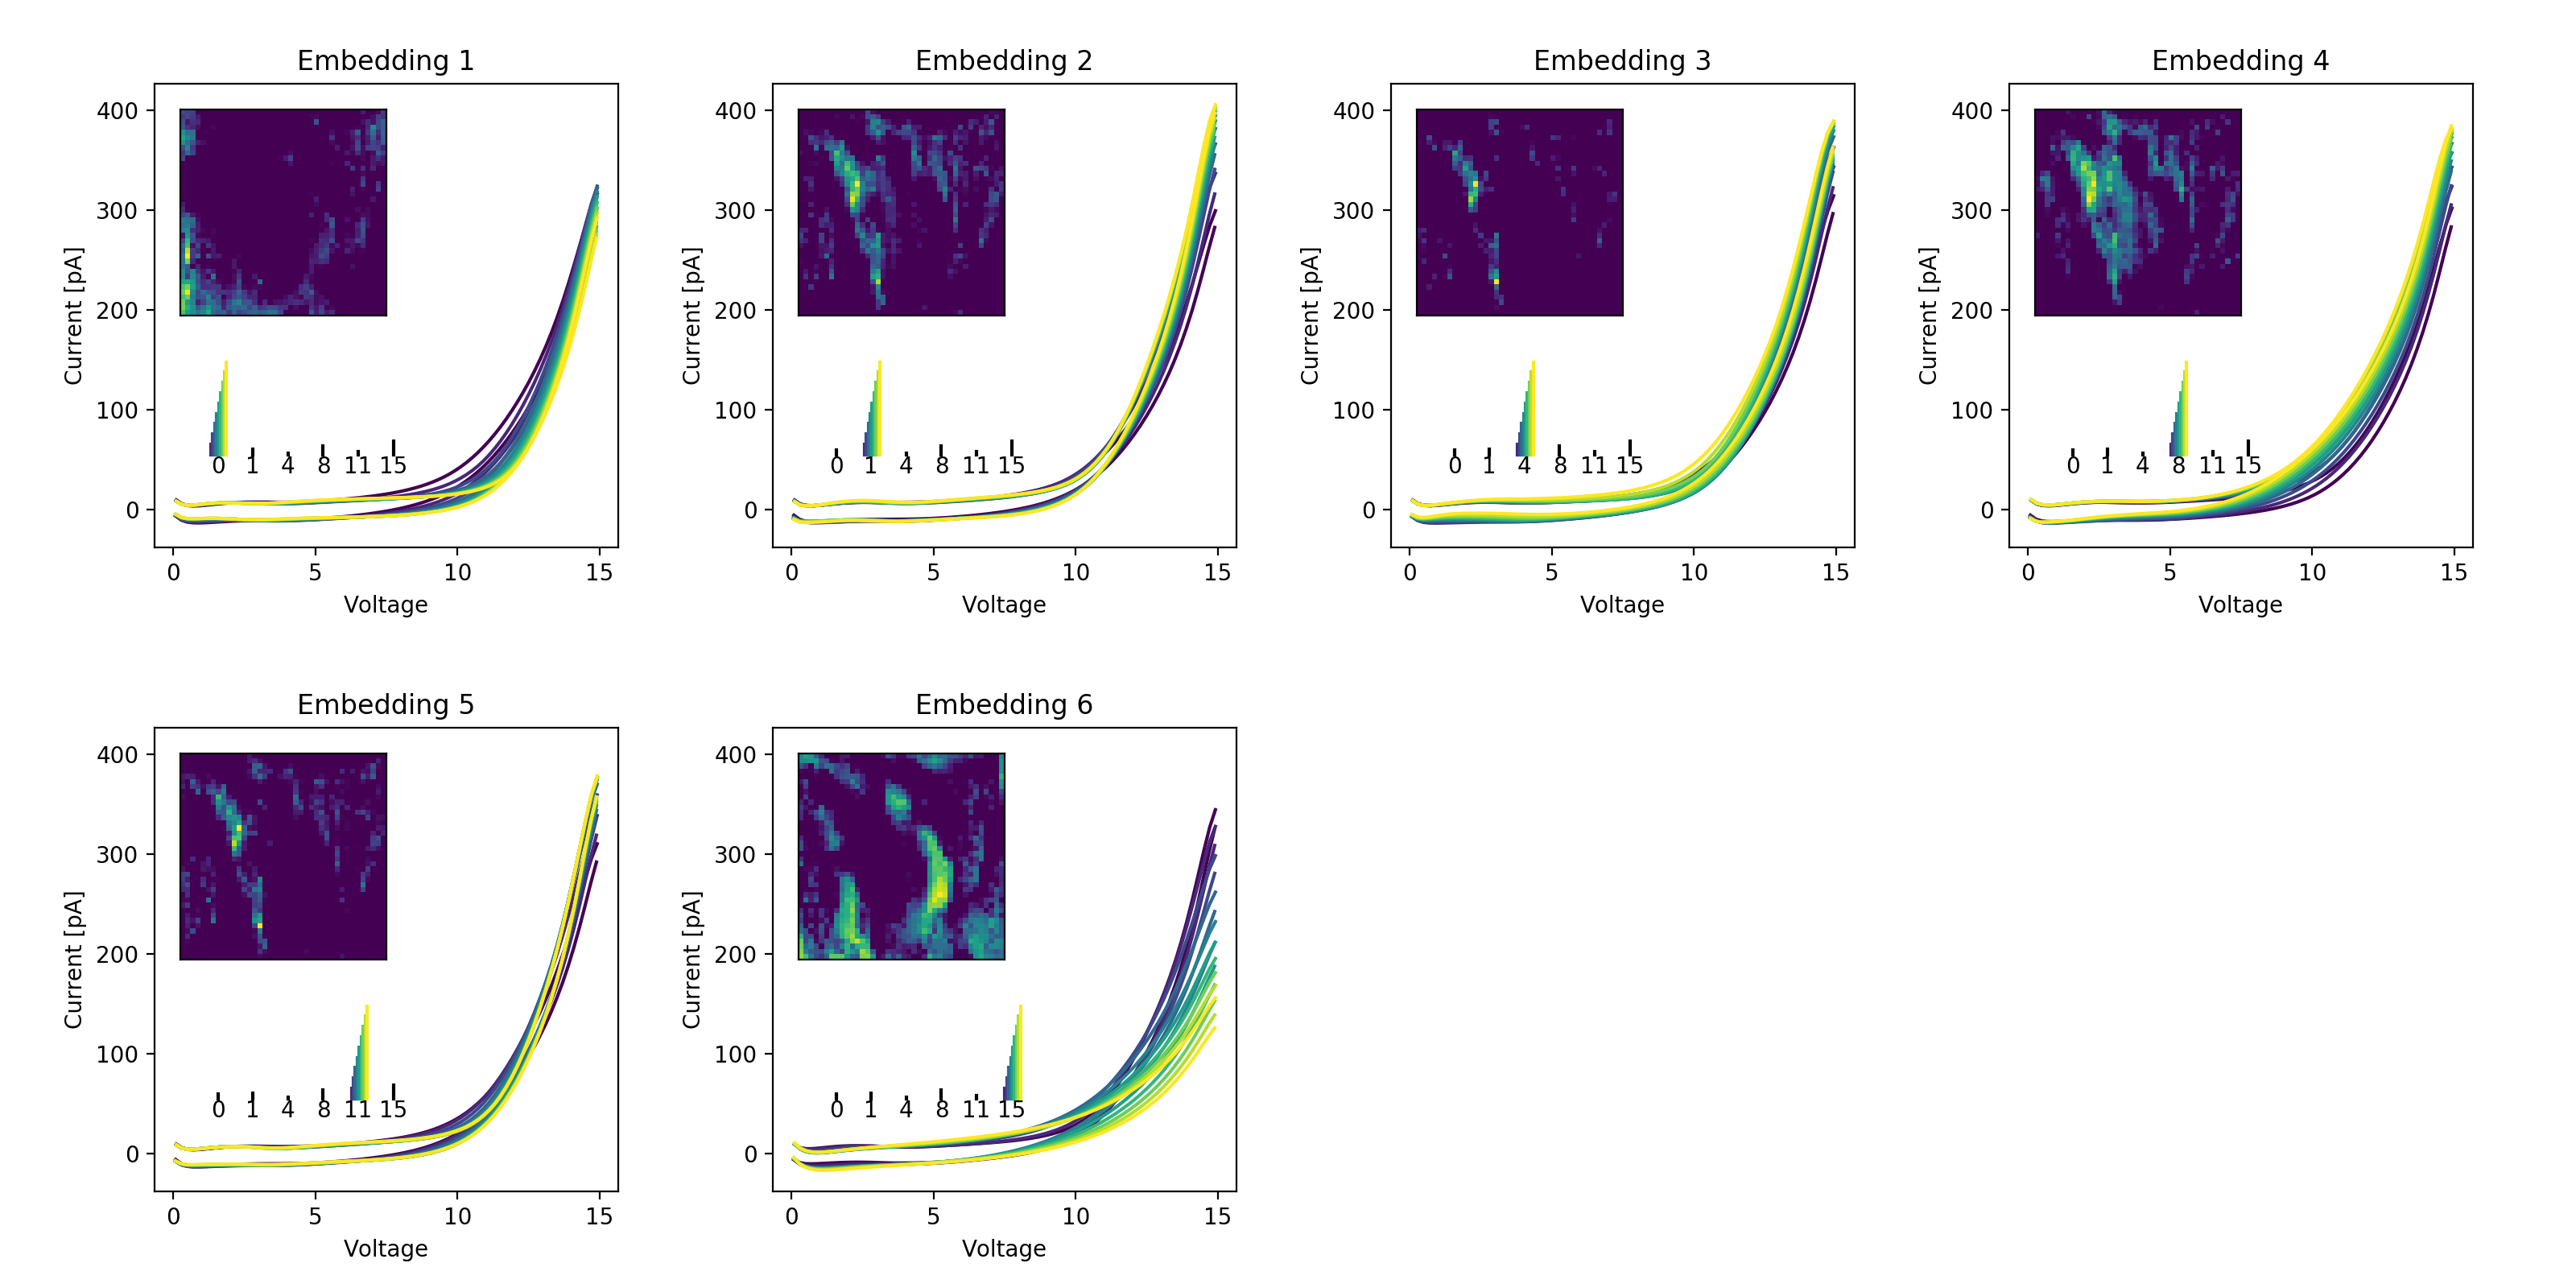

In [4]:
from IPython.display import Image
Image(weights.replace('.hdf5','_CurvesSpecial.png'),)
